<hr/>

#  Foundations of Reinforcement Learning

<hr/>

<h1><font color="darkblue">Lab 6: On-policy Control with Function Approximation </font></h1>





##  Content
1. Episodic Semi-gradient SARSA
2. Differencial Semi-gradient SARSA for Continuing Problem



Import Gym and other necessary libraries

In [1]:
import gym
import itertools
import matplotlib
import numpy as np
import pandas as pd
import sys
import time
import timeit
from collections import namedtuple
import os
import glob


from matplotlib import pyplot as plt
from matplotlib import cm


import io
import base64


import Tilecoding

Please examine and practice "Tilecoding.py" and the following code carefully to get start with tile-coding as well as predict and update in q-function. 

In [166]:
class QEstimator():
    """
    Linear action-value (q-value) function approximator for 
    semi-gradient methods with state-action featurization via tile coding. 
    """
    
    def __init__(self, step_size, num_tilings=8, max_size=4096, tiling_dim=None):
        

        self.max_size = max_size
        self.num_tilings = num_tilings
        self.tiling_dim = tiling_dim or num_tilings

        # Step size is interpreted as the fraction of the way we want 
        # to move towards the target. To compute the learning rate alpha,
        # scale by number of tilings. 
        self.alpha = step_size / num_tilings

        # Initialize index hash table (IHT) for tile coding.
        # This assigns a unique index to each tile up to max_size tiles.
        # Ensure max_size >= total number of tiles (num_tilings x tiling_dim x tiling_dim)
        # to ensure no duplicates.
        self.iht = Tilecoding.IHT(max_size)


        self.weights = np.zeros(max_size)


        # Tilecoding software partitions at integer boundaries, so must rescale
        # position and velocity space to span tiling_dim x tiling_dim region.
        self.position_scale = self.tiling_dim / (env.observation_space.high[2] \
                                                  - env.observation_space.low[2])
        self.velocity_scale = self.tiling_dim / (env.observation_space.high[2]*2 \
                                                  - env.observation_space.low[2]*2)
        
    def featurize_state_action(self, state, action):
        """
        Returns the featurized representation for a 
        state-action pair.
        """
        featurized = Tilecoding.tiles(self.iht, self.num_tilings, 
                           [self.position_scale * state[2], 
                            self.velocity_scale * state[3]], 
                           [action])
        return featurized
    
    def predict(self, s, a=None):
        """
        Predicts q-value(s) using linear FA.
        If action a is given then returns prediction
        for single state-action pair (s, a).
        Otherwise returns predictions for all actions 
        in environment paired with s.   
        """
    
        if a is None:
            features = [self.featurize_state_action(s, i) for 
                        i in range(env.action_space.n)]
        else:
            features = [self.featurize_state_action(s, a)]
            
        return [np.sum(self.weights[f]) for f in features]
        
            
    # def update(self, s, a, target):
    #     """
    #     Updates the estimator parameters
    #     for a given state and action towards
    #     the target using the gradient update rule 
    #     """
    #     features = self.featurize_state_action(s, a)
    #     estimation = np.sum(self.weights[features])  # Linear FA

    #     delta = (target - estimation)
        
    #     self.weights[features] += self.alpha * delta

    def update(self, state, action, reward, next_state, next_action, is_episodic=False):
        features = self.featurize_state_action(state, action)
        estimation = np.sum(self.weights[features])

        if is_episodic:
            target = reward + self.alpha * (self.weights[self.featurize_state_action(next_state, next_action)] -
                                            self.weights[self.featurize_state_action(state, action)])
        else:
            target = reward + self.alpha * (self.weights[self.featurize_state_action(next_state, next_action)])

        delta = target - estimation
        self.weights[features] += self.alpha * delta
        

In [106]:
def make_epsilon_greedy_policy(estimator, epsilon, num_actions):
    """
    Creates an epsilon-greedy policy based on a 
    given q-value approximator and epsilon.    
    """
    def policy_fn(observation):
        action_probs = np.ones(num_actions, dtype=float) * epsilon / num_actions
        q_values = estimator.predict(observation)
        best_action_idx = np.argmax(q_values)
        action_probs[best_action_idx] += (1.0 - epsilon)
        return action_probs
    return policy_fn

def get_epsilon(t):
    return max(0.1, min(1., 1. - np.log10((t + 1) / 25)))

### 1. Episodic Semi-gradient SARSA
1. Apply Episodic Semi-gradient SARSA (See Sutton&Barto Section 10.1) to the carpole example for 500 episodes to obtain an approximate optimal policy. 
0. Divide the total 500 episodes into 10 sets. Plot the average reward for each set. (i.e. plot the average reward for the first 50 episodes, the second 50 episodes, ..., and the 10th 50 episodes.) 

In [191]:
#Episodic Semi-gradient SARSA
## Suggested flow: try to complete the algorithm with functions above (OR feel free to modify, add and use other tool)


total_reward = 0


env = gym.make('CartPole-v1')
observation = env.reset()
if gym.__version__>'0.26.0':
    observation = observation[0]


step_size = 0.5  # Fraction of the way we want to move towards target
num_episodes = 5000
set_size = 500

# initialize QEstimator
estimator = QEstimator(step_size=step_size)



gamma = 0.98
result = np.zeros(10)
s = 0
for ep in range(num_episodes):
    if  np.mod(ep,set_size)==0:
        print("Finishing set:",s)
        result[s] = total_reward/set_size
        s+=1
        total_reward = 0

    epsilon = get_epsilon(ep)
    episode_data = []
    
    # get epsilon-greedy policy
    policy = make_epsilon_greedy_policy(
        estimator, epsilon, env.action_space.n)
    
    # end of one episode 
    state = env.reset()
    if gym.__version__>'0.26.0':
        observation = observation[0]
    done = False
    
    # Get the action probs from the policy
    probs = policy(state[0])

    # Select an action based on the probs 
    action = np.random.choice(len(probs), p=probs)
    
    while not done:
        # during one episode
        total_reward += 1
        #################### simulate one step
        if gym.__version__>'0.26.0':
            observation, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
        else:
            observation, reward, done, info = env.step(action) 
        ####################

        # Get probabilities 
        probs = policy(observation)

        # Select an action based on the probs 
        next_action = np.random.choice(len(probs), p=probs)
        next_state = observation
        next_q_value = estimator.predict(next_state, next_action)
        target = reward + gamma * next_q_value[0]  # Assuming next_q_value is a list of size 1
        episode_data.append((state, action, reward, next_state, next_action))
        
        # Set next steps 
        state = next_state
        action = next_action

    # Update values AFTER episode
    # NOTE: This is what makes it episodic
    for i in range(len(episode_data) - 1):
        state, action, reward, next_state, next_action = episode_data[i]
        if len(state) != 4:     # The number of states 
            state = state[0]    # Index the number of states if the tuple has extra junk from gym API
        estimator.update(state, action, reward, next_state, next_action, is_episodic=True)


Finishing set: 0
Finishing set: 1
Finishing set: 2
Finishing set: 3
Finishing set: 4
Finishing set: 5
Finishing set: 6
Finishing set: 7
Finishing set: 8
Finishing set: 9


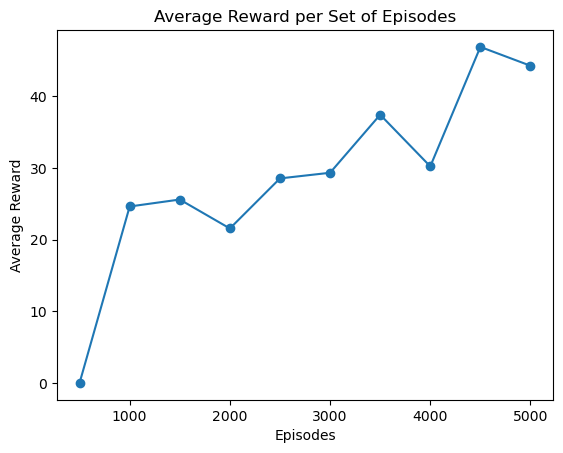

In [192]:
# Plotting the results
import matplotlib.pyplot as plt

episode_sets = [i * set_size for i in range(1, 11)]
plt.plot(episode_sets, result, marker='o')
plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.title('Average Reward per Set of Episodes')
plt.show()

### 2. Differencial Semi-gradient SARSA

Now we view the carpole problem as a continuing problem: In the carpole environment, whenever the agent reaches a non-terminal states, it receives +1 reward; whenever the agent reaches a terminal states, it receives 0 reward, and move to a non-terminal state by reseting the enviornment.

1. Apply Differencial Semi-gradient SARSA (See Sutton&Barto Section 10.3) to this modified carpole example for 500 episodes to obtain an approximate optimal policy. 
0. Divide the total 500 episodes into 10 sets. Plot the average reward for each set. (i.e. plot the average reward for the first 50 episodes, the second 50 episodes, ..., and the 10th 50 episodes.) 

In [173]:
#Differencial Semi-gradient SARSA
## Suggested flow: try to complete the algorithm with functions above (OR feel free to modify, add and use other tool)


total_reward = 0


env = gym.make('CartPole-v1')
observation = env.reset()
if gym.__version__>'0.26.0':
    observation = observation[0]


step_size = 0.5  # Fraction of the way we want to move towards target
num_episodes = 5000
set_size = 500

# initialize QEstimator
estimator = QEstimator(step_size=step_size)



gamma = 0.98
result = np.zeros(10)
s = 0
for ep in range(num_episodes):
    if  np.mod(ep,set_size)==0:
        print("Finishing set:",s)
        result[s] = total_reward/set_size
        s+=1
        total_reward = 0

    epsilon = get_epsilon(ep)
        
    policy = make_epsilon_greedy_policy(
        estimator, epsilon, env.action_space.n)
    
    # end of episode
    state = env.reset()
    if gym.__version__>'0.26.0':
        observation = observation[0]
    done = False
    
    # Initial action selection
    action_probs = policy(state[0])
    action = np.random.choice(env.action_space.n, p=action_probs)

    
    while not done:
        # during one episode
        total_reward += 1
        #################### simulate one step
        if gym.__version__>'0.26.0':
            observation, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
        else:
            observation, reward, done, info = env.step(action) 
        ####################
        
        # Get probabilities 
        probs = policy(observation)

        # Select an action based on the probs 
        next_action = np.random.choice(len(probs), p=probs)
        next_state = observation
        next_q_value = estimator.predict(next_state, next_action)
        
        # Set next steps 
        state = next_state
        action = next_action
        target = reward + gamma * next_q_value[0]  # Assuming next_q_value is a list of size 1

        # Update values during episode
        # NOTE: This is what makes it differential
        estimator.update(state, action, reward, next_state, next_action, False)

Finishing set: 0
Finishing set: 1
Finishing set: 2
Finishing set: 3
Finishing set: 4
Finishing set: 5
Finishing set: 6
Finishing set: 7
Finishing set: 8
Finishing set: 9


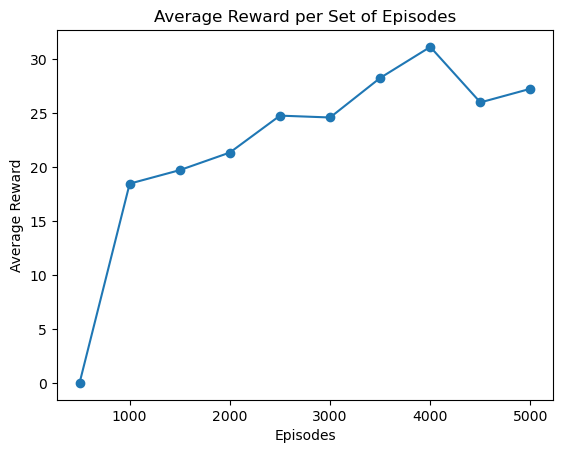

In [174]:
# Plotting the results
import matplotlib.pyplot as plt

episode_sets = [i * set_size for i in range(1, 11)]
plt.plot(episode_sets, result, marker='o')
plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.title('Average Reward per Set of Episodes')
plt.show()